### Goal : Predict count for several days based on the training data set.
Summary
* I do feature engineering to extract some new features from existing ones.
* I explored the data by plotting some of the features and looking at how they affect output. I was also able to get a better understanding of the data and see some trends in the data.
* I used scikit-learn's Random Forest Regression to perform machine learning and learn how the features affect total-count.

In [1]:
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation
from datetime import datetime, date, time

%matplotlib inline

# Read the csv file containing the training data set
filename = r"C:\Users\piush\Desktop\Dataset\BikeSharing/train.csv"
df_train = pd.read_csv(filename, header=0)
num_train = np.int(df_train.shape[0])

# Read the csv file containing the test data set
filename = r"C:\Users\piush\Desktop\Dataset\BikeSharing/test.csv"
df_test = pd.read_csv(filename, header=0)
num_test = np.int(df_test.shape[0])

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Combining train and test data set: I combine the training and test dataset into one dataframe so that any feature engineering I do on the training dataset is also replicated on the test data set.

In [2]:
# Concatenate the 2 data sets
df = pd.concat([df_train,df_test])
num_samples_tot = np.int(df.shape[0])

### Feature engineering
Here I modify some of the features in the dataset to help with the machine learning.
* I extract hour, month, year and date from the timestamp data.
* I determine the weekday based on date.
* I categorize continuous data and create bins.

In [3]:
# Renaming some columns so they make more sense
df=df.rename(columns = {'count':'total_count'}) # since count is also a Dataframe func.

# Convert count to float
df.total_count = df.total_count.astype(np.float)


In [4]:
# Extract month, year and hour information from the timestamp
df['hour'] = df['datetime'].map(lambda x:(datetime.strptime(x, "%Y-%m-%d %H:%M:%S")).hour)
df['month'] = df['datetime'].map(lambda x:(datetime.strptime(x, "%Y-%m-%d %H:%M:%S")).month)
df['year'] = df['datetime'].map(lambda x:(datetime.strptime(x, "%Y-%m-%d %H:%M:%S")).year)
df['date'] = df['datetime'].map(lambda x:(datetime.strptime(x, "%Y-%m-%d %H:%M:%S")).day)

In [5]:
# Convert day information to weekday (Monday (0) to Sunday (6))
df['weekday'] = df['datetime'].map(lambda x:(datetime.strptime(x, "%Y-%m-%d %H:%M:%S")).weekday()) 


In [6]:
# Get labels for bins based on the lower value of each bin
def get_bins(dat,num_bins):
    bins = np.zeros(num_bins)
    for ct in range(num_bins):
        bins[ct] = np.around(np.min(dat)+ct*((np.max(dat) - np.min(dat))/num_bins),decimals = 1)
    return bins

df['temp'] = pd.cut(df.temp, bins = 20,labels = get_bins(df.temp,20))
df['atemp'] = pd.cut(df.atemp, bins = 20,labels = get_bins(df.atemp,20))
df['humidity'] = pd.cut(df.humidity, bins = 20,labels = get_bins(df.humidity,20))
df['windspeed'] = pd.cut(df.windspeed, bins = 20,labels = get_bins(df.windspeed,20))

df['temp'] = df.temp.astype(np.float)
df['atemp'] = df.atemp.astype(np.float)
df['humidity'] = df.humidity.astype(np.float)
df['windspeed'] = df.windspeed.astype(np.float)

In [7]:
# Look at the modified dataframe
df.head(3)

,atemp,casual,total_count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday,hour,month,year,date,weekday
0,12.5,3.0,16.0,2011-01-01 00:00:00,0,80.0,13.0,1,8.9,1,0.0,0,0,1,2011,1,5
1,12.5,8.0,40.0,2011-01-01 01:00:00,0,75.0,32.0,1,8.9,1,0.0,0,1,1,2011,1,5
2,12.5,5.0,32.0,2011-01-01 02:00:00,0,75.0,27.0,1,8.9,1,0.0,0,2,1,2011,1,5


### Exploratory Data Analysis
Here i perform exploratory analysis to understand what features in the dataset might be playing a big role and which ones are not.

In [8]:
def prepare_plot_area(ax):
    # Remove plot frame lines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.spines["left"].set_visible(False) 
    
    # X and y ticks on bottom and left
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()  
    
# Defining a color pattern based
colrcode = [(31, 119, 180), (255, 127, 14),\
             (44, 160, 44), (214, 39, 40), \
             (148, 103, 189),  (140, 86, 75), \
             (227, 119, 194), (127, 127, 127), \
             (188, 189, 34), (23, 190, 207)]

for i in range(len(colrcode)):  
    r, g, b = colrcode[i]  
    colrcode[i] = (r / 255., g / 255., b / 255.)

In [9]:
# How does the casual and registered count change over the course of a day?
wd_tot = df.groupby(['workingday','hour'])['total_count'].mean()
wd_casual = df.groupby(['workingday','hour'])['casual'].mean()
wd_reg = df.groupby(['workingday','hour'])['registered'].mean()

wd_tot_std = df.groupby(['workingday','hour'])['total_count'].std()
wd_casual_std = df.groupby(['workingday','hour'])['casual'].std()
wd_reg_std = df.groupby(['workingday','hour'])['registered'].std()

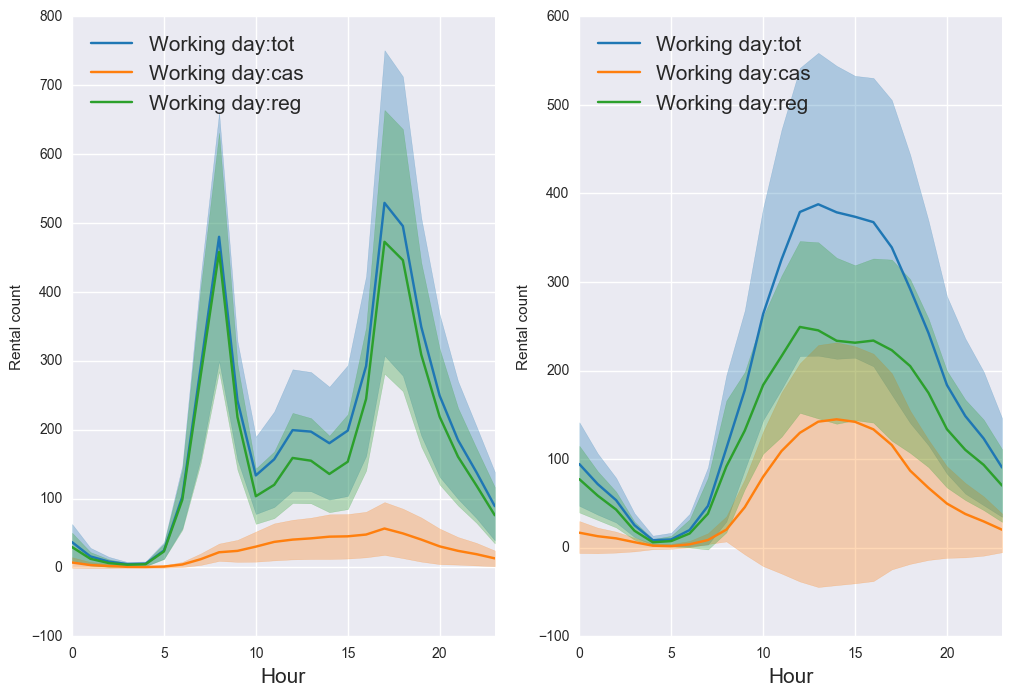

In [10]:
fig,axes = plt.subplots(figsize=(12, 8), nrows=1, ncols=2)
plt.sca(axes[0])
plt.fill_between(list(range(24)),wd_tot[1]-wd_tot_std[1],wd_tot[1]+wd_tot_std[1], color=colrcode[0],alpha = 0.3)
wd_tot[1].plot(kind = 'line',label = 'Working day:tot', color = colrcode[0])

plt.fill_between(list(range(24)),wd_casual[1]-wd_casual_std[1],wd_casual[1]+wd_casual_std[1], color=colrcode[1],alpha = 0.3)
wd_casual[1].plot(kind = 'line',label = 'Working day:cas', color = colrcode[1])

plt.fill_between(list(range(24)),wd_reg[1]-wd_reg_std[1],wd_reg[1]+wd_reg_std[1], color=colrcode[2],alpha = 0.3)
wd_reg[1].plot(kind = 'line',label = 'Working day:reg', color = colrcode[2])

plt.legend(loc='upper left',fontsize = 15)
plt.xlabel('Hour',fontsize = 15)
plt.ylabel('Rental count')
prepare_plot_area(plt.gca())

plt.sca(axes[1])
plt.fill_between(list(range(24)),wd_tot[0]-wd_tot_std[0],wd_tot[0]+wd_tot_std[0], color=colrcode[0],alpha = 0.3)
wd_tot[0].plot(kind = 'line',label = 'Working day:tot', color = colrcode[0])

plt.fill_between(list(range(24)),wd_casual[1]-wd_casual_std[0],wd_casual[0]+wd_casual_std[0], color=colrcode[1],alpha = 0.3)
wd_casual[0].plot(kind = 'line',label = 'Working day:cas', color = colrcode[1])

plt.fill_between(list(range(24)),wd_reg[0]-wd_reg_std[0],wd_reg[0]+wd_reg_std[0], color=colrcode[2],alpha = 0.3)
wd_reg[0].plot(kind = 'line',label = 'Working day:reg', color = colrcode[2])

plt.legend(loc='upper left',fontsize = 15)
plt.xlabel('Hour',fontsize = 15)
plt.ylabel('Rental count')
prepare_plot_area(plt.gca())

There is a lot of information in the above plots that show the mean and standard distribution of count per hour for registered and casual renters on working and non working days.
1. There is a difference in pattern of rent count over the course of the day between working day and a non working day.
2. On a working day, the total count is largely contributed by regitered users. These are probably users using the service to commute to work. We see peaks at around 7-8 am and a peak at 4-6 pm that matches with common commute times.
3. On a non-working day, there is a single large peak from around 11 am to 5 pm.
4. On a non-working day, the contribution to total count is from both casual and registered voters almost equally.

In [11]:
# Looking at how the four weather variables effect count: Temperature, felt-like temperature, humidity and windspeed

temp_reg = df.groupby(['temp'])['registered'].mean()
temp_cas = df.groupby(['temp'])['casual'].mean()
atemp_reg = df.groupby(['atemp'])['registered'].mean()
atemp_cas = df.groupby(['atemp'])['casual'].mean()
humid_reg = df.groupby(['humidity'])['registered'].mean()
humid_cas = df.groupby(['humidity'])['casual'].mean()
windspeed_reg = df.groupby(['windspeed'])['registered'].mean()
windspeed_cas = df.groupby(['windspeed'])['casual'].mean()


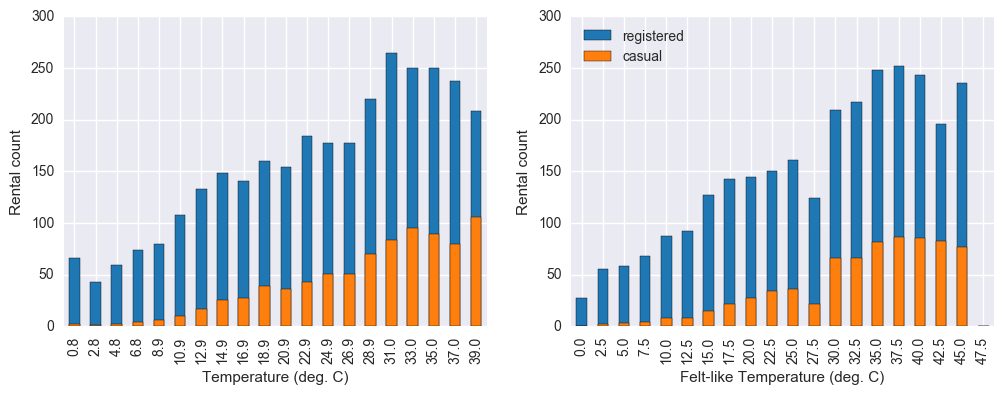

In [12]:
fig,axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
plt.sca(axes[0])
temp_reg.plot(kind = 'bar',color = colrcode[0])
temp_cas.plot(kind = 'bar',color = colrcode[1])
prepare_plot_area(plt.gca())
plt.xlabel('Temperature (deg. C)')
plt.ylabel('Rental count')

plt.sca(axes[1])
atemp_reg.plot(kind = 'bar',color = colrcode[0])
atemp_cas.plot(kind = 'bar',color = colrcode[1])
prepare_plot_area(plt.gca())
plt.xlabel('Felt-like Temperature (deg. C)')
plt.legend(loc = 'upper left')
plt.ylabel('Rental count')

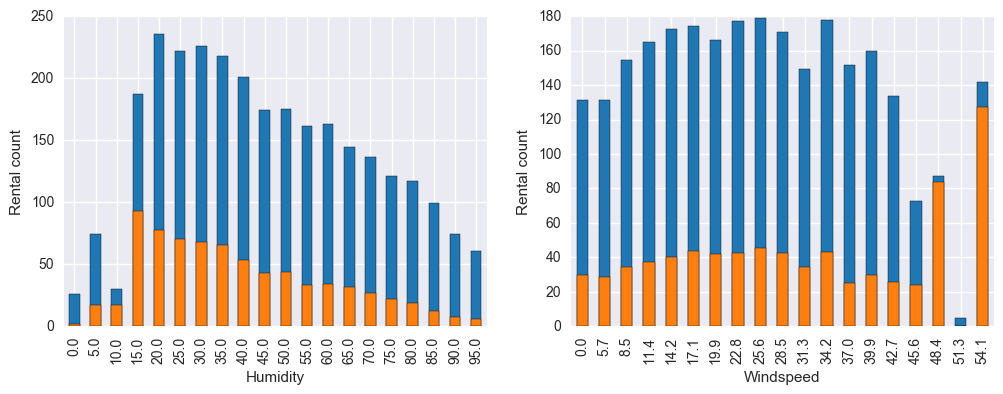

In [13]:
fig,axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
plt.sca(axes[0])
humid_reg.plot(kind = 'bar',color = colrcode[0])
humid_cas.plot(kind = 'bar',color = colrcode[1])
prepare_plot_area(plt.gca())
plt.xlabel('Humidity')
plt.ylabel('Rental count')


plt.sca(axes[1])
windspeed_reg.plot(kind = 'bar',color = colrcode[0])
windspeed_cas.plot(kind = 'bar',color = colrcode[1])
prepare_plot_area(plt.gca())
plt.xlabel('Windspeed')
plt.ylabel('Rental count')

Here is the insight from this:
1. Higher the temperature , more rentals. This makes sense. People would avoid biking when the weather is too cold.
2. Higher the humidity, fewer rentals. What is not clear is why there are fewer rentals when the humidity is close to zero.
3. A medium windspeed is what bikers seem to prefer. However this does not seem to be a strong factor.

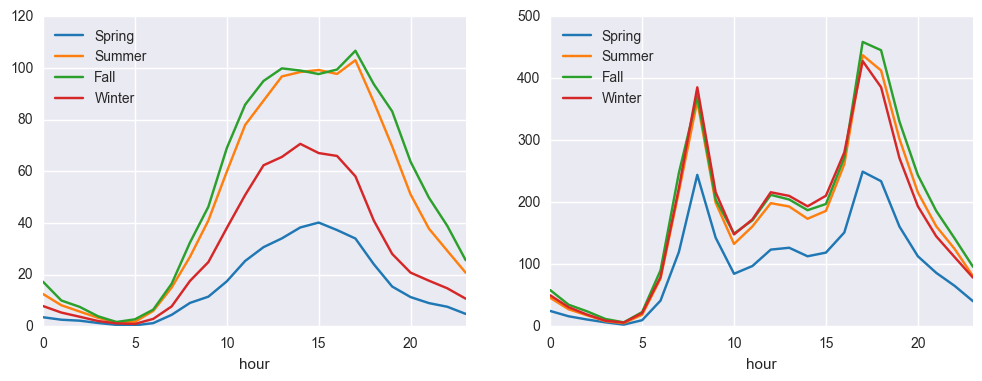

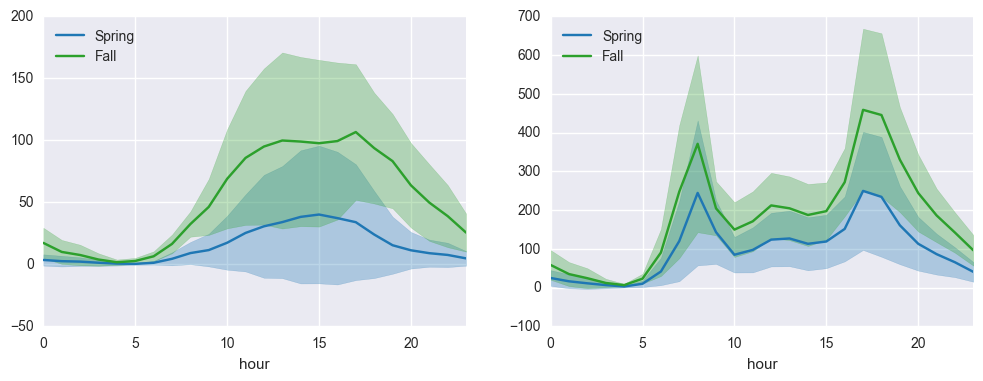

In [14]:
fig,axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
hr = df.groupby(['season','hour'])['casual'].mean()
hr_std = df.groupby(['season','hour'])['casual'].std()
leg = ['Spring','Summer','Fall','Winter']

plt.sca(axes[0])
for i in range(4):
#     plt.fill_between(list(range(24)),hr[i+1]+hr_std[i+1],hr[i+1]-hr_std[i+1], color=colrcode[i],alpha = 0.3)
    hr[i+1].plot(kind = 'line', color = colrcode[i],label = leg[i])
plt.legend(loc = 'upper left')
prepare_plot_area(plt.gca())

hrr = df.groupby(['season','hour'])['registered'].mean()
hrr_std = df.groupby(['season','hour'])['registered'].std()

plt.sca(axes[1])
for i in range(4):
    hrr[i+1].plot(kind = 'line', color = colrcode[i],label = leg[i])
plt.legend(loc = 'upper left')
prepare_plot_area(plt.gca())

fig,axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
plt.sca(axes[0])
for i in [0,2]:
    plt.fill_between(list(range(24)),hr[i+1]+hr_std[i+1],hr[i+1]-hr_std[i+1], color=colrcode[i],alpha = 0.3)
    hr[i+1].plot(kind = 'line',label = leg[i], color = colrcode[i])
plt.legend(loc = 'upper left')
prepare_plot_area(plt.gca())

plt.sca(axes[1])
for i in [0,2]:
    plt.fill_between(list(range(24)),hrr[i+1]+hrr_std[i+1],hrr[i+1]-hrr_std[i+1], color=colrcode[i],alpha = 0.3)
    hrr[i+1].plot(kind = 'line',label = leg[i], color = colrcode[i])
plt.legend(loc = 'upper left')
prepare_plot_area(plt.gca())

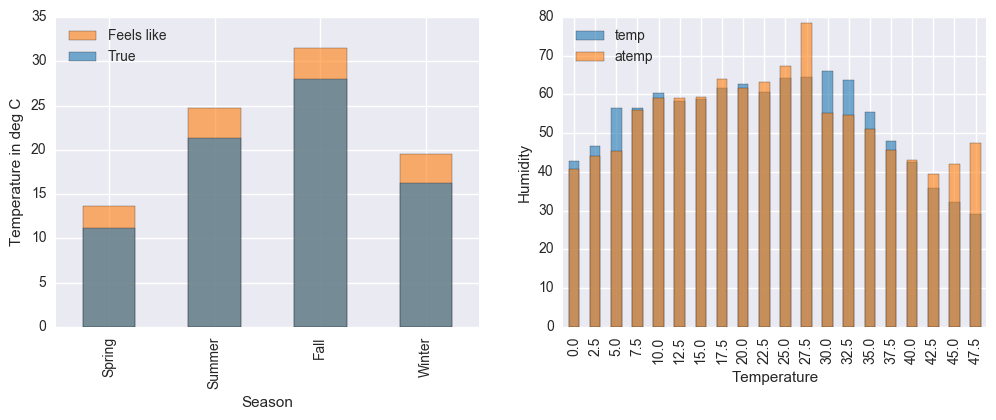

In [15]:
fig,axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
plt.sca(axes[0])
ts = df.groupby(['season'])['temp'].mean()
ats = df.groupby(['season'])['atemp'].mean()
ats.plot(kind = 'bar',x = [0,1,2,3],y = ts,color = colrcode[1],alpha = 0.6,label = 'Feels like')
ts.plot(kind = 'bar',x = [0,1,2,3],y = ts,color = colrcode[0],alpha = 0.6, label = 'True')
plt.xlabel('Season')
plt.xticks([0,1,2,3],leg)
plt.ylabel('Temperature in deg C')
prepare_plot_area(plt.gca())
plt.legend(loc = 'upper left')

plt.sca(axes[1])
ts = df.groupby(['temp'])['humidity'].mean()
ats = df.groupby(['atemp'])['humidity'].mean()
ts.plot(kind = 'bar',x = list(range(len(ts))),y = ts,color = colrcode[0],alpha = 0.6,label = 'temp')
ats.plot(kind = 'bar',x = list(range(len(ts))),y = ts,color = colrcode[1],alpha = 0.6,label = 'atemp')
plt.xlabel('Temperature')
plt.ylabel('Humidity')
prepare_plot_area(plt.gca())
plt.legend(loc = 'upper left')

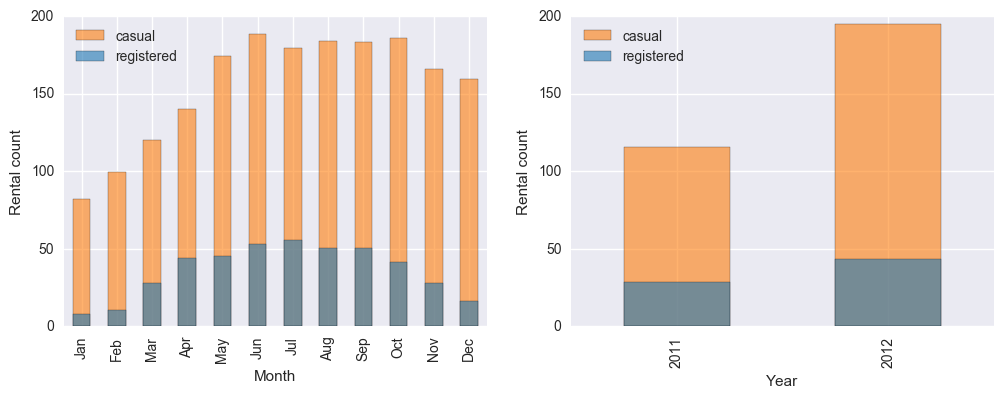

In [16]:
mon_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
fig,axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
plt.sca(axes[0])
ts = df.groupby(['month'])['casual'].mean()
ats = df.groupby(['month'])['registered'].mean()
ats.plot(kind = 'bar',x = list(range(12)),y = ts,color = colrcode[1],alpha = 0.6,label = 'casual')
ts.plot(kind = 'bar',x = list(range(12)),y = ts,color = colrcode[0],alpha = 0.6, label = 'registered')
plt.xlabel('Month')
plt.xticks(list(range(12)),mon_names)
plt.ylabel('Rental count')
prepare_plot_area(plt.gca())
plt.legend(loc = 'upper left')

plt.sca(axes[1])
ts = df.groupby(['year'])['casual'].mean()
ats = df.groupby(['year'])['registered'].mean()
ats.plot(kind = 'bar',x = [0,1],y = ts,color = colrcode[1],alpha = 0.6,label = 'casual')
ts.plot(kind = 'bar',x = [0,1],y = ts,color = colrcode[0],alpha = 0.6, label = 'registered')
plt.xlabel('Year')
plt.xticks(list(range(2)),['2011','2012'])
plt.ylabel('Rental count')
prepare_plot_area(plt.gca())
plt.legend(loc = 'upper left')

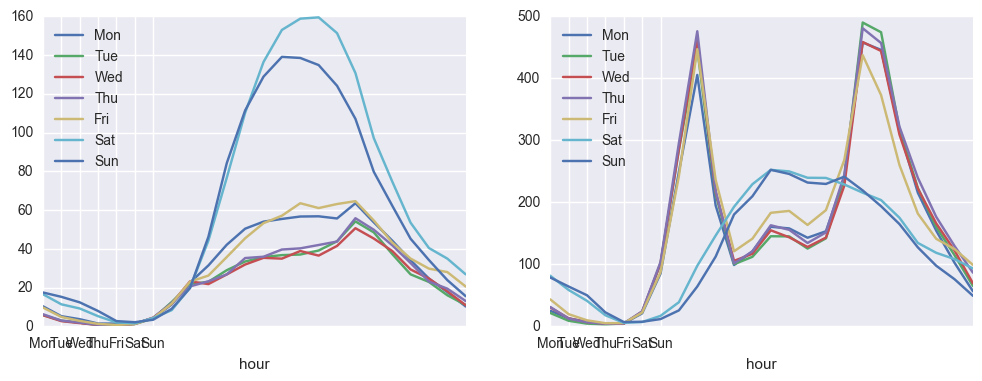

In [17]:
fig,axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
dy_cas = df.groupby(['weekday','hour'])['casual'].mean()
dy_reg = df.groupby(['weekday','hour'])['registered'].mean()
plt.sca(axes[0])
dy = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
for i in range(7):
    dy_cas[i].plot(kind = 'line',label = dy[i])
plt.xticks(list(range(7)),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.legend(loc='upper left')

plt.sca(axes[1])
for i in range(7):
    dy_reg[i].plot(kind = 'line',label = dy[i])
plt.xticks(list(range(7)),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.legend(loc='upper left')

In [18]:
# Convert dataframe to array
def get_array_from_dataframe(df,feature_names):
    df = df[feature_names]
    data = df.values
    data = data.astype(np.float)
    return data

def get_RMSLE(pred,actual):
    n = len(pred)
    return np.sqrt(1/n*(np.sum((np.log(pred+1)-np.log(actual+1))**2)))

def inverse_log(data):
    return np.exp(data)-1
    

def get_RMSE(log_pred,log_actual):
    n = len(log_pred)
    return np.sqrt(1/n*(np.sum((log_pred-log_actual)**2)))

#Normalize continuous variables for regression
def normalize(data):
    data = (data - data.mean()) / (data.max() - data.min())
    return data


# Dummy coding of categorical variables for regression
weat  = pd.get_dummies(data = df['weather'],prefix = 'weat')
seas  = pd.get_dummies(data = df['season'],prefix = 'seas')
wkdy  = pd.get_dummies(data = df['weekday'],prefix = 'wk_dy')
df = pd.concat([df,weat,seas,wkdy],axis = 1)

# df.iloc[0:num_train,:].count()
# Normalize variables for regression
# df['hour'] = normalize(df['hour'])
# df['temp'] = normalize(df['temp'])
# df['humidity'] = normalize(df['humidity'])
# df['windspeed'] = normalize(df['windspeed'])
# df['atemp'] = normalize(df['atemp'])
# df.head(3)
df.head(3)

,atemp,casual,total_count,datetime,holiday,humidity,registered,season,temp,weather,...,seas_2,seas_3,seas_4,wk_dy_0,wk_dy_1,wk_dy_2,wk_dy_3,wk_dy_4,wk_dy_5,wk_dy_6
0,12.5,3.0,16.0,2011-01-01 00:00:00,0,80.0,13.0,1,8.9,1,...,0,0,0,0,0,0,0,0,1,0
1,12.5,8.0,40.0,2011-01-01 01:00:00,0,75.0,32.0,1,8.9,1,...,0,0,0,0,0,0,0,0,1,0
2,12.5,5.0,32.0,2011-01-01 02:00:00,0,75.0,27.0,1,8.9,1,...,0,0,0,0,0,0,0,0,1,0


#### Machine learning to predict registered and casual count needs to be done separately since they have different trends.

In [19]:
def PerformRegression(train_data, regressor):
    train, cv_test = cross_validation.train_test_split(train_data,test_size = 0.3)
    
    regressor.fit(train[:,1::],np.log(train[:,0]+1))
    pred = regressor.predict(cv_test[:,1::])
    pred_train = regressor.predict(train[:,1::])
        
    score_cv = get_RMSE(pred,np.log(cv_test[:,0]+1))
    score_train = get_RMSE(pred_train,np.log(train[:,0]+1))
        
    print('CV Prediction score : ',np.around(score_cv,3),'\nTraining prediction score : ',np.around(score_train,3))
    return regressor

print('The error metric is : Root Mean Squared Logarithmic Error. Hence closer the value is to zero, the better.')

The error metric is : Root Mean Squared Logarithmic Error. Hence closer the value is to zero, the better.


In [20]:
# Define the machine learning regressor
regressor  = RandomForestRegressor(n_estimators = 100, oob_score=True)


In [21]:
# Predicting casual count
feature_names_cas = ['casual','temp','year','month','hour','humidity','atemp','workingday','holiday',\
                 'windspeed','season','weat_1','weat_2','weat_3','weat_4','seas_1','seas_2','seas_3','seas_4',\
                 'wk_dy_0','wk_dy_1','wk_dy_2','wk_dy_3','wk_dy_4','wk_dy_5','wk_dy_6']


In [22]:
data = get_array_from_dataframe(df,feature_names_cas)
train_data = data[:num_train,:]

Regression performed on casual count
CV Prediction score :  0.503 
Training prediction score :  0.185


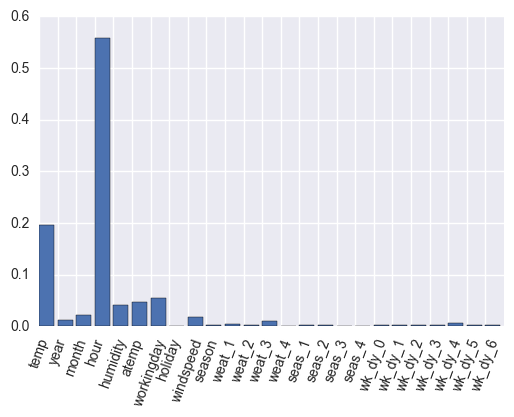

In [23]:
print('Regression performed on casual count')
regressor = PerformRegression(train_data,regressor)
plt.figure()
plt.bar(list(range(len(feature_names_cas)-1)),regressor.feature_importances_)
a = plt.xticks(list(range(len(feature_names_cas)-1)),feature_names_cas[1::],rotation = 70)

Regression performed on registered count
CV Prediction score :  0.299 
Training prediction score :  0.115


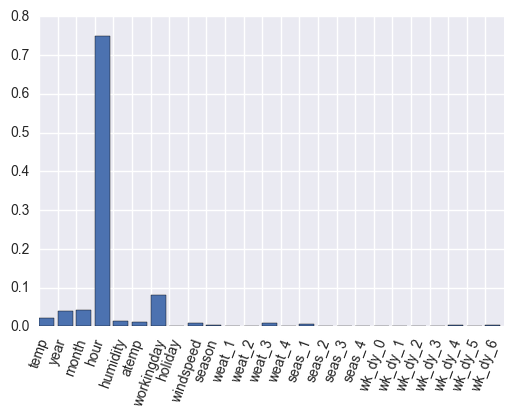

In [24]:
# Predicting registered count
feature_names_reg = ['registered','temp','year','month','hour','humidity','atemp','workingday','holiday',\
                 'windspeed','season','weat_1','weat_2','weat_3','weat_4','seas_1','seas_2','seas_3','seas_4',\
                 'wk_dy_0','wk_dy_1','wk_dy_2','wk_dy_3','wk_dy_4','wk_dy_5','wk_dy_6']
data = get_array_from_dataframe(df,feature_names_reg)
train_data = data[:num_train,:]
print('Regression performed on registered count')
regressor = PerformRegression(train_data, regressor)

plt.figure()
plt.bar(list(range(len(feature_names_reg)-1)),regressor.feature_importances_)
a = plt.xticks(list(range(len(feature_names_reg)-1)),feature_names_reg[1::],rotation = 70)

### Feature importances
Number of casual users depends heavily on temperature, hour of the day and to some extent on wheter it is working day or not, humidity. However, number of registered users depends most heavily on the hour of the day and whether it is a working day or not.
This shows that most registered users are people who use the bike share program to get to work. This is nice to see in the data though not very surprising.

### Predictions
Now to train the regressor on the entire training data set and predict on Kaggle's test set

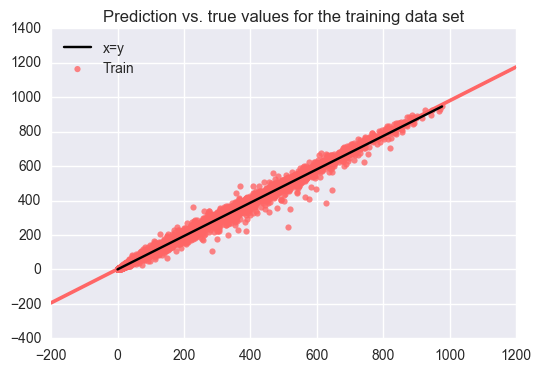

In [25]:
# Predicting the test set
regressor1  = RandomForestRegressor(n_estimators = 100, oob_score=True)
regressor2  = RandomForestRegressor(n_estimators = 100, oob_score=True)

data1 = get_array_from_dataframe(df,feature_names_cas)
train_data1 = data1[:num_train,:]
regressor1.fit(train_data1[:,1::],np.log(train_data1[:,0]+1))

data2 = get_array_from_dataframe(df,feature_names_reg)
train_data2 = data2[:num_train,:]
regressor2.fit(train_data2[:,1::],np.log(train_data2[:,0]+1))

pred_train = np.zeros(len(train_data[:,1::]))
pred_train = inverse_log(regressor1.predict(train_data1[:,1::])) + inverse_log(regressor2.predict(train_data2[:,1::]))

plt.figure()
true_label_train = get_array_from_dataframe(df,'total_count')[:num_train]
sns.regplot(true_label_train,pred_train,color = [1,.4,.4],label = 'Train')
plt.plot([0,np.max(true_label_train)],[0,np.max(pred_train)],color = [0,0,0],label = 'x=y')
plt.legend(loc ='best')
plt.title('Prediction vs. true values for the training data set')


test_data1 = data1[num_train::,:]
test_data2 = data2[num_train::,:]
test_data = np.zeros((len(test_data1),1))
test_data[:,0] = inverse_log(regressor1.predict(test_data1[:,1::])) + inverse_log(regressor2.predict(test_data2[:,1::]))

In [26]:
# Write Predictions on test dat
df_final = pd.DataFrame()
df_final['datetime'] = df_test['datetime']
df_final['count'] = np.round(test_data[:,0])
df_final.to_csv('random_forest.csv',index = False)
print('CSV file created!')

CSV file created!
